## Comprehensive Analysis of Dual-Function AMPs (antimicrobial and anticancer activity)

This notebook includes:

- Dataset construction, with a 90/10 train-test split.

- Feature extraction (descriptors) with hyperparameter optimization (GridSearchCV) and model training.

- Evaluation of ML baseline models: Naive Bayes, Random Forest,  Support Vector Machine (SVM) and Decision Tree.

- Performance metrics, including confusion matrices, for the best predictive model.

- Feature importance and relevance analysis.


In this section, we import the necessary libraries and modules to perform the analysis and ML tasks for predicting peptide activities. 

In [1]:
import pandas as pd
from peptidy.descriptors import compute_descriptors, descriptor_names
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

This script creates a negative dataset by filtering a low-similarity peptide results file. It retains relevant metadata , to ensure the dataset's quality. The filtered data is saved to a new file, low_similarity_metadata.tsv.

In [2]:
import pandas as pd

# Load the low-similarity results
low_similarity_results = pd.read_csv("low_similarity_results.tsv", sep="\t")

# Define the desired columns to keep
desired_columns = [
    "DRAMP_ID", "Sequence", "Sequence_Length", "Name", "Swiss_Prot_Entry", 
    "Family", "Gene", "Source", "Activity", "Protein_existence", 
    "N-terminal_Modification", "C-terminal_Modification", "Other_Modifications", 
    "Stereochemistry", "Cytotoxicity", "Binding_Traget", "Pubmed_ID", 
    "Reference", "Author", "Title"
]

# Filter the DataFrame to keep only the desired columns
filtered_results = low_similarity_results[desired_columns]

# Save the filtered results to a new file
filtered_results.to_csv("low_similarity_metadata.tsv", sep="\t", index=False)

# Print a success message with the number of records
print(f"File 'low_similarity_metadata.tsv' created successfully with {len(filtered_results)} records.")

File 'low_similarity_metadata.tsv' created successfully with 2721 records.


In here we combine a positive and negative  datasets to create a unified dataset. It starts by loading the positive (AMPs) and negative (low similarity) sequences, then labels the positive sequences as 1 and the negative ones as 0. The sequences are standardized to uppercase and duplicates are removed. Finally, the two datasets are concatenated providing a balanced dataset for training and validation

In [3]:
import pandas as pd

# 1. Load the datasets
df_pos = pd.read_excel("filtered_amps_updated.xlsx")
df_neg = pd.read_csv("low_similarity_metadata.tsv", sep="\t")

# 2. Add labels
df_pos["label"] = 1
df_neg["label"] = 0

# 3. Keep only the "Sequence" column and the label
df_pos = df_pos[["Sequence", "label"]]
df_neg = df_neg[["Sequence", "label"]]

# 4. Standardize to uppercase and remove duplicates
df_pos["Sequence"] = df_pos["Sequence"].str.upper()
df_neg["Sequence"] = df_neg["Sequence"].str.upper()

# 5. Concatenate the datasets and remove duplicates by sequence
df_all = pd.concat([df_pos, df_neg], ignore_index=True)

# 6. Check the result
print(f"Total sequences: {len(df_all)}")
print(df_all["label"].value_counts())

Total sequences: 6024
label
1    3303
0    2721
Name: count, dtype: int64


### Feature Extraction from Valid Peptide Sequences

Preprocess peptide sequences and extract meaningful features for machine learning applications. To ensure data consistency and compatibility with feature extraction tools, the sequences are first converted to uppercase and filtered to include only valid amino acids. 

Once the sequences are validated, features are computed for each peptide using descriptor functions. These features capture various physicochemical and structural properties of the peptides, such as molecular weight, isoelectric point, hydrophobicity, and more. The extracted features are then organized into a DataFrame to serve as input (X) for machine learning models. Corresponding labels (y) are also prepared to enable supervised learning tasks, such as classification.

In [5]:
# Convert sequences to uppercase and filter invalid sequences
valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
sequences = df_all["Sequence"].str.upper() 
sequences = sequences[sequences.apply(lambda seq: set(seq).issubset(valid_amino_acids))].tolist()  # Filter valid sequences

# Ensure labels match the filtered sequences
labels = df_all.loc[df_all["Sequence"].str.upper().isin(sequences), "label"].tolist()

# Compute descriptors for each valid sequence
features = [compute_descriptors(seq) for seq in sequences]

# Convert the list of descriptor dictionaries into a DataFrame
X = pd.DataFrame(features)

# Labels remain the same
y = labels

In [6]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import Counter

# Convert sequences to uppercase and filter invalid sequences
valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
sequences = df_all["Sequence"].str.upper() 
sequences = sequences[sequences.apply(lambda seq: set(seq).issubset(valid_amino_acids))].tolist()  # Filter valid sequences

# Ensure labels match the filtered sequences
labels = df_all.loc[df_all["Sequence"].str.upper().isin(sequences), "label"].tolist()

# Compute descriptors for each valid sequence
features = []
for seq in sequences:
    # Compute basic descriptors
    descriptor = compute_descriptors(seq)
    
    # Compute amino acid frequencies
    aa_freq = {aa: seq.count(aa) / len(seq) for aa in valid_amino_acids}
    
    # Compute physicochemical properties using BioPython
    analysis = ProteinAnalysis(seq)
    physicochemical_props = {
        'aromaticity': analysis.aromaticity(),
        'instability_index': analysis.instability_index(),
        'gravy': analysis.gravy(),  # Grand average of hydropathy
        'isoelectric_point': analysis.isoelectric_point()
    }
    
    # Compute bigram frequencies
    bigrams = [seq[i:i+2] for i in range(len(seq) - 1)]
    bigram_counts = Counter(bigrams)
    
    # Combine all features
    combined_features = {**descriptor, **aa_freq, **physicochemical_props, **bigram_counts}
    features.append(combined_features)

# Convert the list of descriptor dictionaries into a DataFrame
X = pd.DataFrame(features).fillna(0)  # Fill missing values with 0

# Labels remain the same
y = labels

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))  # Bigrams and trigrams
X_ngrams = vectorizer.fit_transform(sequences)

### Remove feautures with low variance

In [9]:
from sklearn.feature_selection import VarianceThreshold

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
X_reduced = selector.fit_transform(X)

# Get the remaining feature names
selected_features = X.columns[selector.get_support()]
X = pd.DataFrame(X_reduced, columns=selected_features)

print(f"Number of features after removing low-variance features: {X.shape[1]}")

Number of features after removing low-variance features: 403


### Stratified Train-Test Split

To objectively evaluate the predictive performance of the machine learning models, it is essential to partition the available dataset into separate subsets for training and testing. The training set is used to fit the model, while the test set provides a estimate of its generalization performance on unseen data.

The parameter stratify=y ensures that the class distribution is preserved across both training and testing subsets, which is particularly important for imbalanced datasets. This stratification supports fair performance comparisons across different models. The fixed random_state ensures reproducibility allowing results to be validated and benchmarked consistently across multiple experimental runs.

We use  Train_test_split from scikit-learn to divide the input features X and corresponding labels y into:

- X_train, y_train: 90% of the data used for model training.

- X_test, y_test: 10% of the data reserved for final model evaluation.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

### Class Distribution Analysis to Verify the Dataset Balance

In here we analise class distribution to identify potential imbalances in the dataset. Visualizing the distribution with bar plots helps assess balance and decide if techniques to balance are needed.

Class distribution:
 0    2713
1    2362
Name: count, dtype: int64


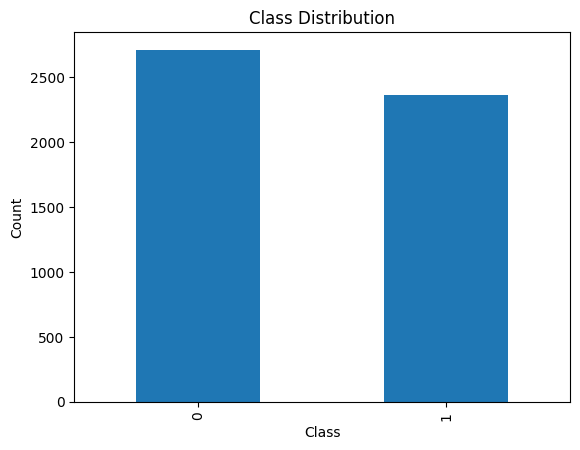

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

class_distribution = pd.Series(y).value_counts()
print("Class distribution:\n", class_distribution)

# Class distribution plot
class_distribution.plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Number of feautures

In [12]:
num_features = X_train.shape[1] 
print(f"Number of features in the dataset: {num_features}")

Number of features in the dataset: 403


### Model Training and Hyperparameter Optimization 

To train and optimize multiple supervised machine learning models for binary classification of peptides by integrating  exhaustive hyperparameter search (GridSearchCV).

- Distinct classifiers are considered: Random Forest, Decision Tree and Naive Bayes. These models offer a range of learning capacities and inductive biases.

- GridSearchCV is used to identify the optimal combination of hyperparameters for each model using 10-fold cross-validation.

- The best hyperparameters and corresponding cross-validated performance are printed for comparative assessment.

        This approach ensures that each model is fairly tuned and evaluated under consistent data balancing 
        and search space conditions.

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline 

# Stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the models and their hyperparameters
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'param_grid': {
            'model__var_smoothing': [1e-10, 1e-11, 1e-12, 1e-13]
        }
    }
}

# Train each model using GridSearchCV 
for model_name, config in models.items():
    print(f"Training {model_name}...")

    # Create a pipeline with just the model
    pipeline = Pipeline([
        ('model', config['model'])
    ])

    # Grid search
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['param_grid'],
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )

    # Train
    grid_search.fit(X_train, y_train)

    # Output best results
    print(f"Best Hyperparameters for {model_name}: {grid_search.best_params_}")
    print(f"Best Cross-Validated F1-Score for {model_name}: {grid_search.best_score_:.4f}")
    print("-" * 50)


Training Random Forest...
Best Hyperparameters for Random Forest: {'model__max_depth': 20, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Best Cross-Validated F1-Score for Random Forest: 0.9366
--------------------------------------------------
Training Decision Tree...
Best Hyperparameters for Decision Tree: {'model__max_depth': 10, 'model__min_samples_split': 2}
Best Cross-Validated F1-Score for Decision Tree: 0.9242
--------------------------------------------------
Training Naive Bayes...
Best Hyperparameters for Naive Bayes: {'model__var_smoothing': 1e-10}
Best Cross-Validated F1-Score for Naive Bayes: 0.8707
--------------------------------------------------


## Accuracy

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline 

# Stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the models and their hyperparameters
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'param_grid': {
            'model__var_smoothing': [1e-10, 1e-11, 1e-12, 1e-13]
        }
    }
}

# Train each model using GridSearchCV without SMOTE
for model_name, config in models.items():
    print(f"Training {model_name}...")

    # Create a pipeline with just the model (no SMOTE)
    pipeline = Pipeline([
        ('model', config['model'])
    ])

    # Grid search
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['param_grid'],
        cv=cv,
        scoring='accuracy',  # Change scoring metric to accuracy
        n_jobs=-1
    )

    # Train
    grid_search.fit(X_train, y_train)

    # Output best results
    print(f"Best Hyperparameters for {model_name}: {grid_search.best_params_}")
    print(f"Best Cross-Validated Accuracy for {model_name}: {grid_search.best_score_:.4f}")
    print("-" * 50)

Training Random Forest...
Best Hyperparameters for Random Forest: {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best Cross-Validated Accuracy for Random Forest: 0.9422
--------------------------------------------------
Training Decision Tree...
Best Hyperparameters for Decision Tree: {'model__max_depth': 10, 'model__min_samples_split': 2}
Best Cross-Validated Accuracy for Decision Tree: 0.9332
--------------------------------------------------
Training Naive Bayes...
Best Hyperparameters for Naive Bayes: {'model__var_smoothing': 1e-10}
Best Cross-Validated Accuracy for Naive Bayes: 0.8807
--------------------------------------------------


## Precision

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline  # agora do sklearn, não do imblearn

# Stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the models and their hyperparameters
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'param_grid': {
            'model__var_smoothing': [1e-10, 1e-11, 1e-12, 1e-13]
        }
    }
}

# Train each model using GridSearchCV without SMOTE
for model_name, config in models.items():
    print(f"Training {model_name}...")

    # Create a pipeline with just the model (no SMOTE)
    pipeline = Pipeline([
        ('model', config['model'])
    ])

    # Grid search
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['param_grid'],
        cv=cv,
        scoring='precision',  # Change scoring metric to precision
        n_jobs=-1
    )

    # Train
    grid_search.fit(X_train, y_train)

    # Output best results
    print(f"Best Hyperparameters for {model_name}: {grid_search.best_params_}")
    print(f"Best Cross-Validated Precision for {model_name}: {grid_search.best_score_:.4f}")
    print("-" * 50)

Training Random Forest...
Best Hyperparameters for Random Forest: {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best Cross-Validated Precision for Random Forest: 0.9561
--------------------------------------------------
Training Decision Tree...
Best Hyperparameters for Decision Tree: {'model__max_depth': 10, 'model__min_samples_split': 2}
Best Cross-Validated Precision for Decision Tree: 0.9605
--------------------------------------------------
Training Naive Bayes...
Best Hyperparameters for Naive Bayes: {'model__var_smoothing': 1e-13}
Best Cross-Validated Precision for Naive Bayes: 0.8802
--------------------------------------------------


### MCC 

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline  # agora do sklearn, não do imblearn
from sklearn.metrics import matthews_corrcoef, make_scorer

# Stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define MCC as a custom scoring function
mcc_scorer = make_scorer(matthews_corrcoef)

# Define the models and their hyperparameters
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'param_grid': {
            'model__var_smoothing': [1e-10, 1e-11, 1e-12, 1e-13]
        }
    }
}

# Train each model using GridSearchCV without SMOTE
for model_name, config in models.items():
    print(f"Training {model_name}...")

    # Create a pipeline with just the model (no SMOTE)
    pipeline = Pipeline([
        ('model', config['model'])
    ])

    # Grid search
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['param_grid'],
        cv=cv,
        scoring=mcc_scorer,  # Use MCC as the scoring metric
        n_jobs=-1
    )

    # Train
    grid_search.fit(X_train, y_train)

    # Output best results
    print(f"Best Hyperparameters for {model_name}: {grid_search.best_params_}")
    print(f"Best Cross-Validated MCC for {model_name}: {grid_search.best_score_:.4f}")
    print("-" * 50)

Training Random Forest...
Best Hyperparameters for Random Forest: {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best Cross-Validated MCC for Random Forest: 0.8844
--------------------------------------------------
Training Decision Tree...
Best Hyperparameters for Decision Tree: {'model__max_depth': 10, 'model__min_samples_split': 2}
Best Cross-Validated MCC for Decision Tree: 0.8674
--------------------------------------------------
Training Naive Bayes...
Best Hyperparameters for Naive Bayes: {'model__var_smoothing': 1e-10}
Best Cross-Validated MCC for Naive Bayes: 0.7603
--------------------------------------------------


## Support Vector Machine (SVM) with Dedicated Grid Search

Due to the longer runtime of SVMs and the nature of the kernel hyperparameter tuning, we opted to run SVM separately using a more focused grid search strategy. The pipeline was structured to:

- Apply SMOTE for balancing the training folds.

- Optimize over the regularization parameter (C) using a linear kernel, which is especially well-suited for high-dimensional biological datasets.

- Use 5-fold cross-validation during GridSearchCV to reduce computational cost while maintaining robustness.

The SVM’s dedicated training ensured its hyperparameters were explored thoroughly without hindering the training efficiency of the other models.

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Define the pipeline 
pipeline = Pipeline([
    ('model', SVC(random_state=42))
])

# Hyperparameter grid (linear kernel only)
param_grid = {
    'model__C': [0.001, 0.001, 0.1, 1, 10],
    'model__kernel': ['linear']
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Fit and evaluate
grid_search.fit(X_train, y_train)
y_pred = grid_search.best_estimator_.predict(X_test)
f1 = f1_score(y_test, y_pred)

# Output
print("Best Hyperparameters for SVM:", grid_search.best_params_)
print(f"F1-Score on Test Set for SVM: {f1:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters for SVM: {'model__C': 0.1, 'model__kernel': 'linear'}
F1-Score on Test Set for SVM: 0.9142


## ROC curves

The curve provides insight into the trade-off between correctly identifying positive cases and incorrectly classifying negative cases as positive.In this code, ROC curves are generated for multiple models to compare their performance. The curves allow us to visually assess which model performs better across different thresholds, while the AUC provides a quantitative measure of their overall performance. 

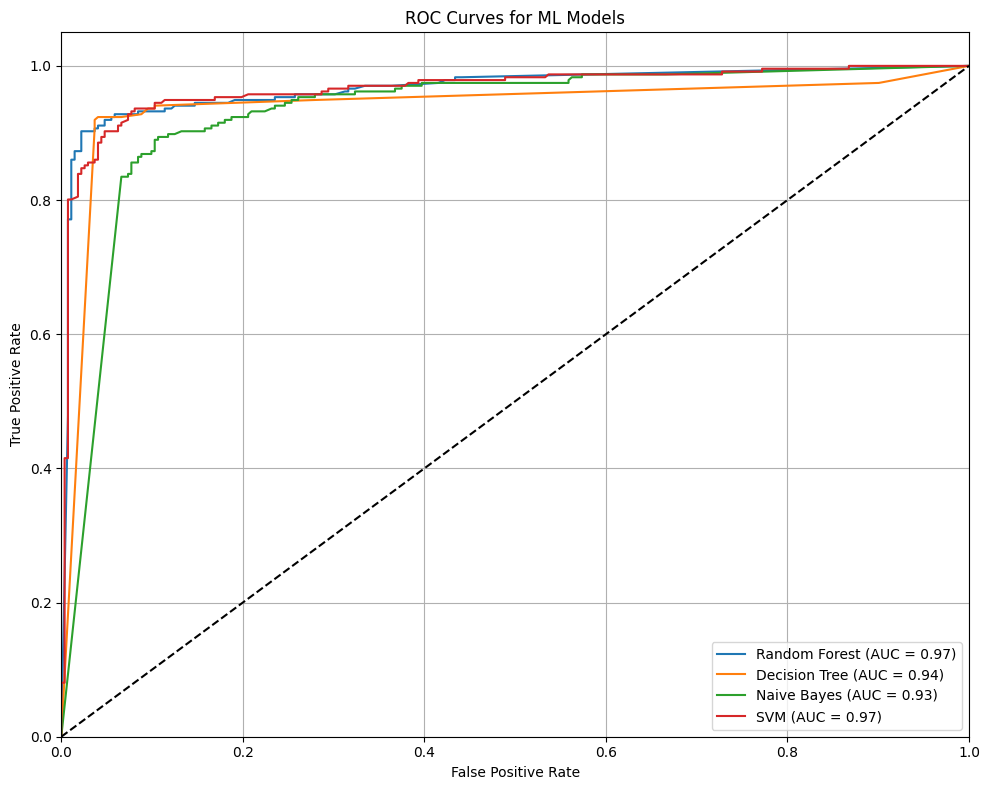

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Define best models 
models = {
    'Random Forest': Pipeline([
        ('model', RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42))
    ]),
    'Decision Tree': Pipeline([
        ('model', DecisionTreeClassifier(max_depth=20, min_samples_split=5, random_state=42))
    ]),
    'Naive Bayes': Pipeline([
        ('model', GaussianNB(var_smoothing=1e-12))
    ]),
    'SVM': Pipeline([
        ('model', SVC(C=0.1, kernel='linear', probability=True, random_state=42))
    ])
}

# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for ML Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Performance Metrics and Confusion Matrix

To rigorously evaluate the generalization ability of the Random Forest and Decision Tree models, the best estimators selected via GridSearchCV with 10-fold cross-validation, were retrained on the entire training set and subsequently tested on the test set (10% of the data). The objective was to classify antimicrobial peptides into two categories: dual-function AMPs (positive class) and AMPs without dual- function (negative class) based on the 403 extracted descriptors.

The predictive performance was assessed through:

- A confusion matrix, providing a quantitative overview of the classification results by displaying the number of true positives, false positives, true negatives, and false negatives.

- A classification report, which summarizes the main evaluation metrics: precision, recall, F1-score, and accuracy, offering a comprehensive picture of the model’s performance on unseen data.

Confusion Matrix for Random Forest:
[[262  10]
 [ 20 216]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       272
           1       0.96      0.92      0.94       236

    accuracy                           0.94       508
   macro avg       0.94      0.94      0.94       508
weighted avg       0.94      0.94      0.94       508



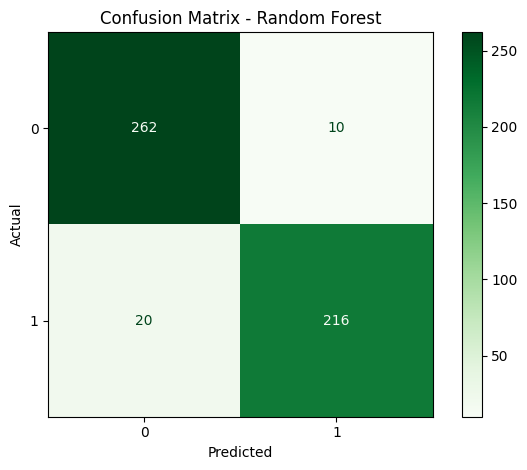

In [34]:
from sklearn.pipeline import Pipeline  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the best Random Forest parameters
best_rf_params = {
    'n_estimators': 200,
    'max_depth': 20,
    'min_samples_split': 10
}

# Create and fit the pipeline
best_rf_pipeline = Pipeline([
    ('model', RandomForestClassifier(
        n_estimators=best_rf_params['n_estimators'],
        max_depth=best_rf_params['max_depth'],
        min_samples_split=best_rf_params['min_samples_split'],
        random_state=42
    ))
])

# Train on the full training set
best_rf_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = best_rf_pipeline.predict(X_test)

# Print confusion matrix and classification report
print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    best_rf_pipeline,
    X_test,
    y_test,
    cmap=plt.cm.Greens,
    colorbar=True,
    display_labels=["0", "1"]
)

plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Decision Tree

Since the Decision Tree achieved the second-best F1-Score, it is important to evaluate its performance on the test set.

The confusion matrix is used to visualize the model's performance by showing the counts of true positives, true negatives, false positives, and false negatives. Additionally, the classification report provides detailed metrics such as precision, recall, and F1-Score for each class. The graphical representation of the confusion matrix helps in better understanding the model's strengths and weaknesses in classifying the data.

Confusion Matrix for Decision Tree (Without SMOTE):
[[262  10]
 [ 23 213]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       272
           1       0.96      0.90      0.93       236

    accuracy                           0.94       508
   macro avg       0.94      0.93      0.93       508
weighted avg       0.94      0.94      0.93       508



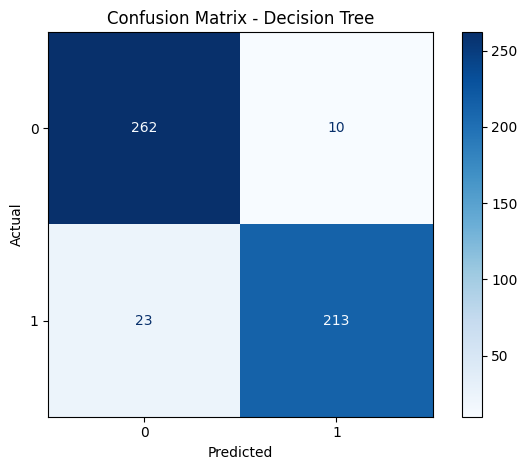

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Define the best Decision Tree parameters
best_dt_params = {
    'max_depth': 10,
    'min_samples_split': 2
}

# Create and fit the pipeline
best_dt_pipeline = Pipeline([
    ('model', DecisionTreeClassifier(
        max_depth=best_dt_params['max_depth'],
        min_samples_split=best_dt_params['min_samples_split'],
        random_state=42
    ))
])

# Train on the full training set
best_dt_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = best_dt_pipeline.predict(X_test)

# Print confusion matrix and classification report
print("Confusion Matrix for Decision Tree (Without SMOTE):")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    best_dt_pipeline,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    colorbar=True,
    display_labels=["0", "1"]
)

plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In here we evaluates the performance of a Random Forest and Decision Tree classifiers using the best hyperparameters. It trains the model on the training set and evaluates it on both the training and test sets, using F1-Score and Accuracy as performance metrics. The script prints the evaluation results for both sets, followed by detailed classification reports that provide additional metrics such as precision, recall, and support. This process helps assess the model's predictive capabilities and generalization performance.

In [36]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

# Define the best Random Forest parameters
best_rf_params = {
    'n_estimators': 200,
    'max_depth': 20,
    'min_samples_split': 10
}


rf_model = RandomForestClassifier(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    random_state=42
)

rf_model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = rf_model.predict(X_train)

# Predict on the test set
y_test_pred = rf_model.predict(X_test)

# Evaluate performance on the training set
train_f1 = f1_score(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate performance on the test set
test_f1 = f1_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print results
print("Performance on Training Set:")
print(f"F1-Score: {train_f1:.4f}")
print(f"Accuracy: {train_accuracy:.4f}")
print("\nPerformance on Test Set:")
print(f"F1-Score: {test_f1:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

# Classification reports for detailed metrics
print("\nClassification Report (Training Set):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Performance on Training Set:
F1-Score: 0.9687
Accuracy: 0.9713

Performance on Test Set:
F1-Score: 0.9351
Accuracy: 0.9409

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2441
           1       0.98      0.95      0.97      2126

    accuracy                           0.97      4567
   macro avg       0.97      0.97      0.97      4567
weighted avg       0.97      0.97      0.97      4567


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       272
           1       0.96      0.92      0.94       236

    accuracy                           0.94       508
   macro avg       0.94      0.94      0.94       508
weighted avg       0.94      0.94      0.94       508



## Interpretability of Model Predictions Through Feature Relevance

To better understand the underlying biological determinants of dual antimicrobial and anticancer activity, we performed a feature importance analysis based on the trained Random Forest model. This step aims to identify which sequence-derived and physicochemical descriptors most strongly contributed to the model’s classification decisions. By ranking the features according to their relative importance, we gain insights into the specific properties that distinguish multifunctional peptides, supporting the interpretability and biological relevance of the predictive framework.

### Top 20 feautures Random Forest

Top 20 Features by Importance:
                            Feature  Importance
11                              n_C    0.075518
12                              n_H    0.064877
10                           length    0.061160
19   topological_polar_surface_area    0.056200
15                              n_S    0.049945
14                              n_O    0.048813
18                    n_h_acceptors    0.048008
16                 molecular_weight    0.045548
9                 isoelectric_point    0.043361
4    average_number_rotatable_bonds    0.035511
17                       n_h_donors    0.032546
13                              n_N    0.023261
23                            gravy    0.020264
155                              CK    0.019626
159                              KC    0.017531
1                            freq_K    0.016676
20                                K    0.016416
3                            freq_R    0.011381
6              energy_based_on_logP    0.010282
22       

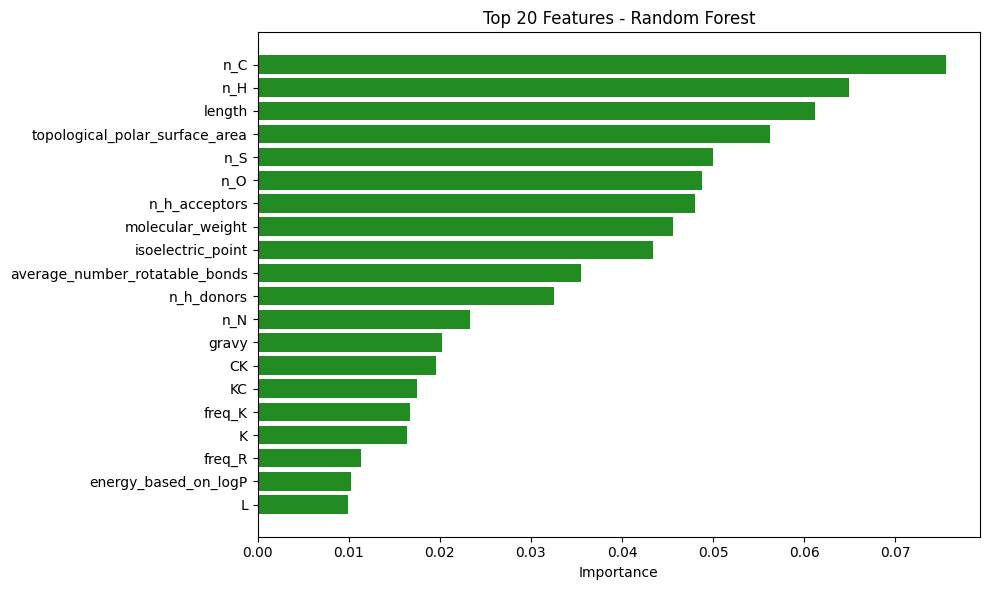

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Get feature names from the training data
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"feature_{i}" for i in range(X_train.shape[1])]

# Create a DataFrame with feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort features by importance and select the top 20
top_20_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Print the top 20 features
print("Top 20 Features by Importance:")
print(top_20_features)


plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'][::-1], top_20_features['Importance'][::-1], color='forestgreen')
plt.xlabel('Importance')
plt.title('Top 20 Features - Random Forest')
plt.tight_layout()
plt.show()

Overall, the top features selected by the model align well with known biophysical principles of AMP function. The predominance of charge-related and polarity-based descriptors reinforces the central role of electrostatic interactions and amphipathic design in driving both antimicrobial and anticancer effects. These findings not only validate the machine learning model but also provide mechanistic insights that can guide future rational design of multifunctional therapeutic peptides.